## Using EpiNT for Pathology Detection

### 1. Short Introduction

In the paper of our work, we described five classification tasks related to epilepsy. One of them is pathology detection, which classifies pathology signals from physiology signals. To illustrate the performance of EpiNT, and increase the credibility of our work, we use MAYO dataset as one example to exam our EpiNT.

### 2. Load Configurations and EpiNT

In [ ]:
import torch

from yaml import CLoader as Loader
from yaml import dump, load
from argparse import Namespace
from sklearn.metrics import f1_score, accuracy_score

from epint.model.EpiNTModel import EpiNT
from epint.data.make_datasets import create_downstream_dataloaders

In [2]:
def read_yaml(file):
    with open(file, 'r') as f:
        return load(f, Loader=Loader)

def merge_config(base_config, new_config):
    for key, value in new_config.items():
        base_config[key] = value
    return base_config

In [3]:
finetune_config_path = '../configs/finetune_configs.yaml'
default_config_path = '../configs/default.yaml'

finetune_config = read_yaml(finetune_config_path)
default_config = read_yaml(default_config_path)
merged_config = merge_config(default_config, finetune_config)

# convert config to arguments
args = Namespace(**merged_config)
print(merged_config)

{'patch_len': 256, 'stride_len': 256, 'sequence_len': 3072, 'dropout': 0.1, 'cls_token': True, 'downstream_dataset': '/home/ZRK/ZRK_ssd2/ZRK/Engineering_Server/Epileptogenic/dataset/downstream_wo_sfreq_equal_cpres_chn.hdf5', 'RESULTS_DIR': '/home/ZRK/sda_data/zrkdata/Epileptogenic_Results/', 'experiment_name': 'linear_probing', 'seizure_task': 'hfo_ied_detec2', 'model_name': 'EpiNT', 'patch_mask': False, 'mask_ratio': 0, 'head_dropout': 0.1, 'task': 'classification', 'd_model': 512, 'dim_feedforward': 2048, 'num_heads': 8, 'num_layers': 6, 'codebook_dim': 64, 'codebook_size': 256, 'num_quantizer': 1, 'optimizer_name': 'AdamW', 'lr_scheduler_type': 'onecyclelr', 'pct_start': 0.3, 'init_lr': 0.0001, 'three_phase': False, 'weight_decay': 0.05, 'num_workers': 4, 'max_norm': 5.0, 'max_epoch': 10, 'train_ratio': 0.7, 'train_batch_size': 1024, 'debug': True, 'seed': 666, 'run_name': '20241226_015111'}


In [4]:
"""
The loaded weights have been pre-trained on the curated 1199 patients dataset, and fine-tuned on MAYO dataset using linear-probing method.
The classification head is trained for distinguish between physiological and pathological signals.
"""
model = EpiNT(args)

# load finetune weights
finetune_weights_path = '../weights/finetune_on_MAYO.bin'
finetune_weights = torch.load(finetune_weights_path)
model.load_state_dict(finetune_weights, strict=True)


<All keys matched successfully>

### 3. Load Dataset

The MAYO dataset contains 59574 samples in the training set, and 12393 samples in the evaluation set. Since the loaded model weights have fine-tuned on the training dataset, we only use the evaluation dataset here. 

Note: MAYO dataset is open access, we have no rights to re-distribute its original or pre-processed version. So we only illustrate the results of evaluation to increase credibility. For those who want to reproduce the experiments, we have included its download link in dataset_configs.yaml, and codes to pre-process it in pre_downstream_dataset.py, please refer to these two files.

In [5]:
# create dataloaders
_, val_loader, _ = create_downstream_dataloaders(file_path=args.downstream_dataset,
                                                 batch_size = args.train_batch_size, 
                                                 seizure_task = args.seizure_task)

Total patients: ['patient_0', 'patient_1', 'patient_14', 'patient_16', 'patient_17', 'patient_18', 'patient_2', 'patient_20', 'patient_21', 'patient_23', 'patient_3', 'patient_4', 'patient_5', 'patient_7', 'patient_8']
Train patients: ['patient_0', 'patient_14', 'patient_16', 'patient_17', 'patient_18', 'patient_2', 'patient_20', 'patient_21', 'patient_23', 'patient_5', 'patient_7', 'patient_8']
Vali patients: ['patient_4', 'patient_1', 'patient_3']
Train data shape: (59574, 3072), (59574, 1)
Vali data shape: (12383, 3072), (12383, 1)


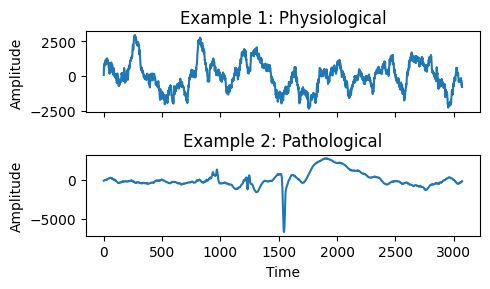

In [6]:
# Extract one example from the validation set for illustration
example_data, example_label = val_loader.dataset[25]
example_data1, example_label1 = val_loader.dataset[10023]

label_dict = {
    0: 'Pathological',
    1: 'Physiological'
}

# plot two example data
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, figsize=(5, 3), sharex=True)

axes[0].plot(example_data.numpy())
axes[0].set_title(f'Example 1: {label_dict[example_label.item()]}')
axes[0].set_ylabel('Amplitude')

axes[1].plot(example_data1.numpy())
axes[1].set_title(f'Example 2: {label_dict[example_label1.item()]}')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()



### 4. Evaluation

In [7]:
# evaluate model's performance (F1 Score and accuracy)
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data, labels in val_loader:
        data, labels = data, labels
        outputs, _ = model(data)
        
        print(f'outputs shape: {outputs.shape}, labels shape: {labels.shape}')

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

f1 = f1_score(all_labels, all_preds, average='binary')
accuracy = accuracy_score(all_labels, all_preds)
print(f'F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

# The results is within the standard deviation of the results reported in the paper.

outputs shape: torch.Size([1024, 2]), labels shape: torch.Size([1024])
outputs shape: torch.Size([1024, 2]), labels shape: torch.Size([1024])
outputs shape: torch.Size([1024, 2]), labels shape: torch.Size([1024])
outputs shape: torch.Size([1024, 2]), labels shape: torch.Size([1024])
outputs shape: torch.Size([1024, 2]), labels shape: torch.Size([1024])
outputs shape: torch.Size([1024, 2]), labels shape: torch.Size([1024])
outputs shape: torch.Size([1024, 2]), labels shape: torch.Size([1024])
outputs shape: torch.Size([1024, 2]), labels shape: torch.Size([1024])
outputs shape: torch.Size([1024, 2]), labels shape: torch.Size([1024])
outputs shape: torch.Size([1024, 2]), labels shape: torch.Size([1024])
outputs shape: torch.Size([1024, 2]), labels shape: torch.Size([1024])
outputs shape: torch.Size([1024, 2]), labels shape: torch.Size([1024])
F1 Score: 0.9157, Accuracy: 0.8512


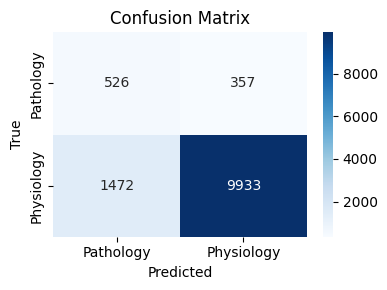

In [8]:
# plot confusion matrix
# 0: pathology, 1: physiology
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pathology', 'Physiology'], yticklabels=['Pathology', 'Physiology'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()